### Newton polynomial interpolation

__MATH 420__<br>
_Spring 2021_<br>

To start, let's build a function that evaluates a linear combination of Newton polynomials. The linear combination is
$$
    x \mapsto c_1 + c_2 (x - x_1) + c_3 (x-x_1)(x-x_2) +  c_4  (x-x_1)(x-x_2) (x-x_3) + \cdots
$$
The inputs will be the polynomial variable $x$, an array of coefficients $c$, and an array of the knots $x$. Our function uses a Horner-like scheme. Accordingly, we loop through the coefficients from high to low. The Julia way to loop backwards is to use `for k in n:-1:1`.

When the number of coefficients doesn't match the number of knots, throw an error.

In [255]:
"""
    newton_interpolation(x::T, c::Vector{T}, knots::Vector{T}) where T <: Real

newton_interpolation(x::T, c::Vector{T}, knots::Vector{T}) where T <: Real  

Evaluate the Newton interpolation polynomial at the given point `x`.

# Arguments
- `x::T`: The point at which to evaluate the polynomial.
- `c::Vector{T}`: The coefficients of the Newton polynomial.
- `knots::Vector{T}`: The knots (nodes) used in the Newton polynomial.

# Returns
- The value of the Newton interpolation polynomial at `x`.

# Error
- Throw an error when the number of coefficients is not equal to the number of knots.
"""
function newton_interpolation(x::T, c::Vector{T}, knots::Vector{T}) where T <: Real
   n = length(c)
   length(knots) == n || error("The number of coefficients must match the number of knots.")
   s = zero(T) # initialize accumulator `s` to zero
   for k in n:-1:1
      s = fma(s, x - knots[k], c[k]) # was c[k] + s*(x - knots[k])
    end
    s 
end;

In [256]:
using Gadfly

Let's test this; say our polynomial is

In [257]:
P = x -> 46 + 107*(x-1) + 28 * (x-1)*(x-2)

#277 (generic function with 1 method)

The function $Q$ should exactly match the function $P$.

In [258]:
Q  = x -> newton_interpolation(x, [46.0,107.0,28.0],[1.0,2.0,3.0])

#279 (generic function with 1 method)

Define a function `D` that is the difference of the functions `P` and `Q`. The function `D` should be the zero function.

In [259]:
D = x -> P(x) - Q(x)

#281 (generic function with 1 method)

First plot both `P` and `Q` on the same graph. These functions should be the same. They appear to be the same.

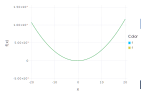

In [260]:
plot([P,Q],-20,20)

Second, plot the function `D`. It should be close to the zero function. It is.

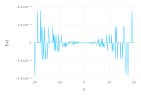

In [261]:
plot(D,-20,20)

Here is a somewhat tricky function that finds the diagonal entries of the Newton divided difference table for a function $f$ with an array of knots $x$.

In [262]:
"""
    newton_divided_diff(f::Function, x::Vector{T}) where T <: Real

Compute the coefficients of the Newton divided difference polynomial for a given function and set of nodes.

# Arguments
- `f::Function`: The function to interpolate.
- `x::Vector{T}`: The set of nodes (knots) at which `f` is evaluated, where `T` is a subtype of `Real`.

# Returns
- `Vector{T}`: The coefficients of the Newton polynomial.

"""
function newton_divided_diff(f::Function, x::Vector{T}) where T <: Real
    n = length(x)
    c = map(f,x) # evaluate function at each node to initialize coefficients 
    for j in 2:n
         for i in n : -1 : j
            c[i]=(c[i]-c[i-1])/(x[i]-x[i-(j-1)])
        end
    end
    c
end

newton_divided_diff

Should we trust this for a self-driving car, or should we test it first?  Let's test it first.  For the polynomial
$$
   x \mapsto 46 + 107(x-1) + 28 (x-1)(x-2),
$$
the diagonal terms of the Newton divided difference table is $[46, 107, 28]$. Let's test

In [263]:
newton_divided_diff(x -> 46 + 107(x-1) + 28 * (x-1)*(x-2), [1.0, 2.0,3.0])

3-element Vector{Float64}:
  46.0
 107.0
  28.0

Yes, it's true--the value of the last knot doesn't matter:

In [264]:
newton_divided_diff(x -> 46 + 107*(x-1) + 28 * (x-1)*(x-2), [1.0, 2.0,1932.0])

3-element Vector{Float64}:
  46.0
 107.0
  28.0

Let's interpolate the sine function; we'll use six equally spaced knots in the interval $[-\pi, \pi]$.

In [265]:
N = 5;

In [266]:
knots = [-pi + 2*pi*k/N for k in 0:N];

In [267]:
c = newton_divided_diff(x -> sin(x), knots);

The graph of the interpolated sine function and the sine function should be pretty much equal on the interval $[-\pi, \pi]$. They are

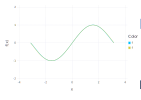

In [268]:
plot([x -> newton_interpolation(x,c,knots), x -> sin(x)], -pi, pi)

Let's look at a graph of the difference between these functions. The difference should be small--it is. It looks like the maximum difference is about 0.03.

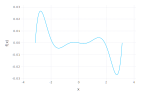

In [269]:
plot([x -> newton_interpolation(x,c,knots) - sin(x)], -pi,pi)

Let's try something wild and crazy. We'll interpolate the factorial function.  Actually, let's try the reciprocal of the factorial function. We must use knots that are integers.

In [270]:
knots = [k for k in 0 : 20];

In [271]:
function myfac(x)
    convert(Float64, 1/factorial(x))
end

myfac (generic function with 1 method)

Pretty cool--the Newton polynomial coefficients appear to diminish toward zero.

In [272]:
c = newton_divided_diff(myfac, knots)

21-element Vector{Float64}:
  1.0
  0.0
 -0.25
  0.1111111111111111
 -0.02604166666666666
  0.003888888888888887
 -0.0003568672839506168
  8.03099017384722e-6
  3.8192722111993095e-6
 -8.535721673214345e-7
  ⋮
  1.035930200459105e-9
 -7.594054033631826e-11
  4.788386981046789e-12
 -2.583746450355194e-13
  1.157364207038593e-14
 -3.8748062704785725e-16
  4.940429781608778e-18
  5.806790994735158e-19
 -6.751558890400561e-20

In [273]:
PP = x -> newton_interpolation(x,c,map(s -> convert(Float64,s), knots))

#297 (generic function with 1 method)

In [274]:
PP(1.2)

0.9081093486788723

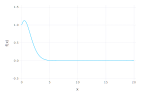

In [275]:
plot(PP,0,20)

The gamma function interpolates the factorial function, effectively extending the factorial function to the real line. Actually, for $k \in \mathbf{Z}_{> -1}$, we have
$$
  \Gamma(k) = (k-1)!
$$
Julia's gamma function is in a package `SpecialFunctions`. The first time you use this package, you will need to use the package manager to add it.

In [276]:
using SpecialFunctions

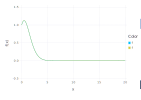

In [277]:
plot([PP, x -> 1/gamma(x+1)],0,20)

In [278]:
D = x -> PP(x) - 1/gamma(x+1)

#303 (generic function with 1 method)

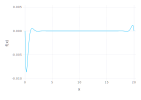

In [279]:
plot(D,0,20)